In [77]:
import gymnasium as gym 
from gymnasium import spaces
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import make_interp_spline
from stable_baselines3 import SAC
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.callbacks import BaseCallback

In [78]:
class MAB(gym.Env):
    def __init__(self, probs, T):
        """
        初始化多臂老虎机环境
        probs: 每个臂的成功概率
        T: 总时间步数
        """
        super(MAB, self).__init__()
        self.k = len(probs)  # 臂的数量
        self.probs = probs  # 每个臂的成功概率
        self.T = T  # 总时间步数

        # 定义动作空间和观察空间
        self.action_space = spaces.Box(low=1, high=100, shape=(1,), dtype=np.float32)  # 动作空间为alpha\in[1,100]代指UCB算法中的探索因子
        self.observation_space = spaces.Box(low=0, high=np.inf, shape=(3 * self.k + 1,))  # 观察空间为(3*k+1)维向量，每个维度包含三个元素：拉臂的次数、获得的奖励、奖励的方差，以及最后一个元素是时间t
        self.reset()

    def reset(self, seed=None, options=None):
        """
        重置环境
        返回: 初始状态
        """
        super().reset(seed=seed)
        self.steps = 0
        self.n = np.zeros(self.k)  # 每个臂的拉动次数
        self.average_rewards = np.zeros(self.k)  # 每个臂奖励的均值
        self.rewards = [[] for _ in range(self.k)]  # 每个臂的奖励列表
        self.var = np.zeros(self.k) # 每个臂奖励的方差
        self.alpha = 1.0  # 初始alpha值
        observation = np.zeros(3 * self.k + 1)  # 初始状态
        info = {}
        return observation, info
    
    def step(self, action):
        """
        执行给定的动作，并返回结果。
        
        参数:
        action: 智能体选择的alpha值
        
        返回:
        - next_state: 执行动作后的新状态
        - reward: 执行动作后获得的奖励
        - terminated: 布尔值，表示是否达到终止状态
        - truncated: 布尔值，表示是否由于时间限制或其他原因而被截断
        - info: 额外的诊断信息（可选）
        """
        self.alpha = action[0]  # 更新alpha值

        ucb_values = self.average_rewards + np.sqrt(self.alpha * np.log(self.steps + 1) / (2 * (self.n + 1e-10)))
        chosen_arm = np.argmax(ucb_values)  # 选择具有最高UCB值的臂
        reward = np.random.binomial(1, self.probs[chosen_arm])  # 根据奖励概率生成奖励
        
        self.steps += 1
        self.n[chosen_arm] += 1
        self.rewards[chosen_arm].append(reward)  # 更新奖励列表
        self.average_rewards[chosen_arm] = np.mean(self.rewards[chosen_arm])  # 更新奖励均值
        self.var[chosen_arm] = np.var(self.rewards[chosen_arm])#更新奖励方差
        terminated = self.steps >= self.T  # 判断是否达到最大步数
        truncated = self.steps >= self.T  # 在这个示例中，截断条件与终止条件相同
        next_state = np.concatenate([self.n, self.average_rewards, self.var, [self.steps]])  # 更新状态
        info = {} # 可选的额外信息

        return next_state, reward, terminated, truncated, info


In [79]:
# 创建环境
np.random.seed(1)
probs = np.random.rand(5)
formatted_probs = [f"{prob:.4f}" for prob in probs]
print("伯努利多臂老虎机的概率为：", formatted_probs)
T = 50
env = MAB(probs,T)

class CustomCallback(BaseCallback):
    def __init__(self, verbose=0):
        super(CustomCallback, self).__init__(verbose)

    def _on_step(self) -> bool:
        # 打印当前时间步
        print(f"当前时间步: {self.num_timesteps}")
        return True
# 创建模型
model = SAC("MlpPolicy", env ,gamma=1,verbose=2) #  我们模型中的折线因子为1

# 创建自定义回调函数实例
callback = CustomCallback()

# 训练模型，并传入回调函数
model.learn(total_timesteps=10000, log_interval=4, callback=callback)

# 保存模型
model.save("sac_multi_armed_bandit")


伯努利多臂老虎机的概率为： ['0.4170', '0.7203', '0.0001', '0.3023', '0.1468']
Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
当前时间步: 1
当前时间步: 2
当前时间步: 3
当前时间步: 4
当前时间步: 5
当前时间步: 6
当前时间步: 7
当前时间步: 8
当前时间步: 9
当前时间步: 10
当前时间步: 11
当前时间步: 12
当前时间步: 13
当前时间步: 14
当前时间步: 15
当前时间步: 16
当前时间步: 17
当前时间步: 18
当前时间步: 19
当前时间步: 20
当前时间步: 21
当前时间步: 22
当前时间步: 23
当前时间步: 24
当前时间步: 25
当前时间步: 26
当前时间步: 27
当前时间步: 28
当前时间步: 29
当前时间步: 30
当前时间步: 31
当前时间步: 32
当前时间步: 33
当前时间步: 34
当前时间步: 35
当前时间步: 36
当前时间步: 37
当前时间步: 38
当前时间步: 39
当前时间步: 40
当前时间步: 41
当前时间步: 42
当前时间步: 43
当前时间步: 44
当前时间步: 45
当前时间步: 46
当前时间步: 47
当前时间步: 48
当前时间步: 49
当前时间步: 50
当前时间步: 51
当前时间步: 52
当前时间步: 53
当前时间步: 54
当前时间步: 55
当前时间步: 56
当前时间步: 57
当前时间步: 58
当前时间步: 59
当前时间步: 60
当前时间步: 61
当前时间步: 62
当前时间步: 63
当前时间步: 64
当前时间步: 65
当前时间步: 66
当前时间步: 67
当前时间步: 68
当前时间步: 69
当前时间步: 70
当前时间步: 71
当前时间步: 72
当前时间步: 73
当前时间步: 74
当前时间步: 75
当前时间步: 76
当前时间步: 77
当前时间步: 78
当前时间步: 79
当前时间步: 80
当前时间步: 81
当前时间步: 82
当前时间步: 83
当前时间步: 84
当前时间步: 85


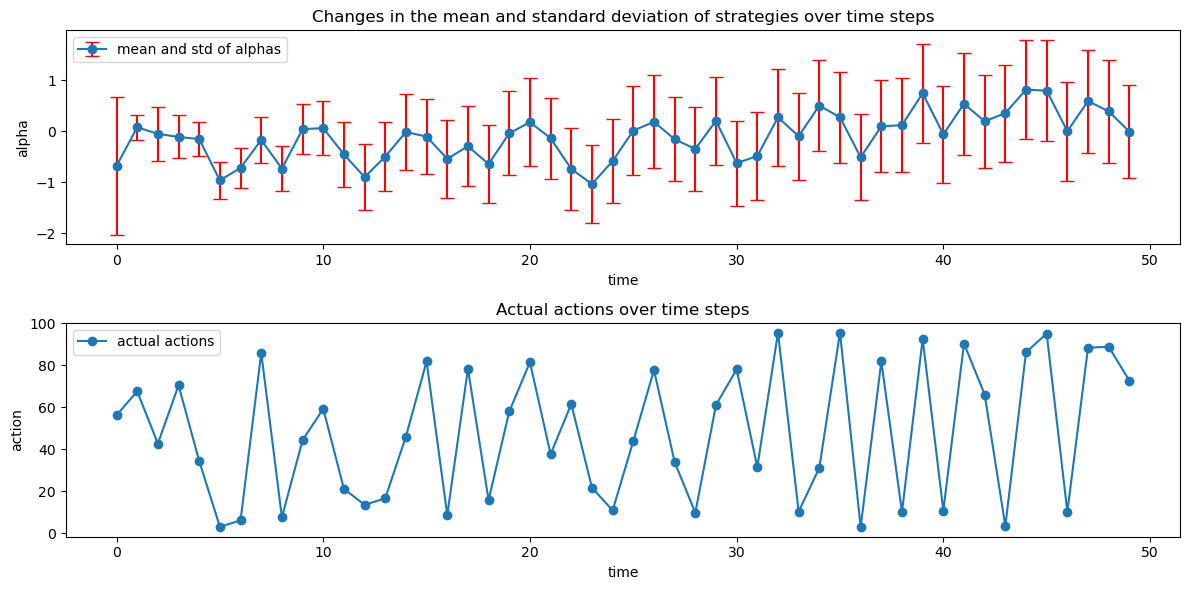

伯努利多臂老虎机的概率为： ['0.4170', '0.7203', '0.0001', '0.3023', '0.1468']
拉臂次数: [16.  8.  9.  8.]
臂收益均值: [0.3333 0.875  0.     0.3333 0.125 ]
臂收益方差: [0.2222 0.1094 0.     0.2222 0.1094]
总收益: 21.0


In [80]:
import torch as th
# 加载训练好的模型
model = SAC.load("sac_multi_armed_bandit")

# 重置环境，获取初始状态
state, _ = env.reset()

# 确保状态是一个 NumPy 数组
state = np.array(state)

# 初始化记录均值和标准差的列表
means = []
stds = []
actions = []
# 运行 T 步
for t in range(T):
    # 将状态转换为 PyTorch 张量，并添加批量维度
    state_tensor = th.tensor(state, dtype=th.float32).unsqueeze(0)
    action, _ = model.predict(state_tensor, deterministic=False) #  随机策略，高斯分布采样+裁剪

    # 获取动作分布参数
    mean_actions, log_std, _ = model.policy.actor.get_action_dist_params(state_tensor)
    std = th.exp(log_std)
    # 记录均值和标准差
    means.append(mean_actions.detach().numpy().flatten())
    stds.append(std.detach().numpy().flatten())
    actions.append(action)
    # 与环境进行交互
    next_state, reward, terminated, truncated, info = env.step(action)

    # 更新状态
    state = next_state
# 将均值、标准差和实际动作转换为 NumPy 数组
means = np.array(means)
stds = np.array(stds)
actions = np.array(actions)

# 绘制均值和标准差随时间步的变化
time_steps = np.arange(T)
plt.figure(figsize=(12, 6))

plt.subplot(2, 1, 1)
plt.errorbar(time_steps, means.flatten(), yerr=stds.flatten(), fmt='-o', ecolor='r', capsize=5, label='mean and std of alphas')
plt.xlabel('time')
plt.ylabel('alpha')
plt.title('Changes in the mean and standard deviation of strategies over time steps')
plt.legend()

# 绘制实际采取的动作随时间步的变化
plt.subplot(2, 1, 2)
plt.plot(time_steps, actions.flatten(), '-o', label='actual actions')
plt.xlabel('time')
plt.ylabel('Alpha')
plt.title('Actual actions over time steps')
plt.legend()

plt.tight_layout()
plt.show()

k = len(probs)
self_n = state[:k]
self_average_rewards = state[k:2*k]
total_reward = np.sum(self_n * self_average_rewards)
# 打印最终状态和总收益
formatted_probs = [f"{prob:.4f}" for prob in probs]
print("伯努利多臂老虎机的概率为：", formatted_probs)

print("拉臂次数:", state[1:k])
print("臂收益均值:",np.round(state[k:2*k], 4))
print("臂收益方差:",np.round(state[2*k:3*k], 4))
print("总收益:", total_reward)